# Análisis Dataset Fraudes: EDA y Selección de Variables

## Librerías

In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import warnings

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option("max_colwidth", 100)

In [2]:
def get_deviation_of_mean_perc(df, list_var_continuous, target, multiplier):
    """
    Devuelve el porcentaje de valores que exceden del intervalo de confianza
    :type series:
    :param multiplier:
    :return:
    """
    pd_final = pd.DataFrame()
    
    for i in list_var_continuous:
        
        series_mean = df[i].mean()
        series_std = df[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = df[i].size
        
        perc_goods = df[i][(df[i] >= left) & (df[i] <= right)].size/size_s
        perc_excess = df[i][(df[i] < left) | (df[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(df[target][(df[i] < left) | (df[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('index',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = df[i][(df[i] < left) | (df[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final

def cramers_v(var1,var2):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher,
    Journal of the Korean Statistical Society 42 (2013): 323-328
    
    confusion_matrix: tabla creada con pd.crosstab()
    
    """
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    chi2 = stats.chi2_contingency(crosstab)[0]
    n = crosstab.sum()
    phi2 = chi2 / n
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def plot_feature(df, col_name, isContinuous, target):
    """
    Visualize a variable with and without faceting on the loan status.
    - df dataframe
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,10), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)


    if isContinuous:
        sns.boxplot(x=col_name, y=target, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by '+target)
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index() 
        data.columns = [i, target, 'proportion']
        #sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        ax2.set_ylabel(target+' fraction')
        ax2.set_title(target)
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()

    
def plot_fraud(df, col_name):
    """
    Visualize a variable with and without faceting on the loan status.
    - df dataframe
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    
    sns.countplot(df[col_name], color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)
    
    plt.tight_layout()


## Carga y display de los datos

In [3]:
file_data = '../data/Copia de Original_dataset_payments_fraud.csv'
file_dict = '../data/Book1.xlsx'
data = pd.read_csv(file_data, sep=';')
dictionary = pd.read_excel(file_dict)

In [4]:
dictionary

Variable  \
0                step   
1                type   
2              amount   
3              gender   
4              device   
5     connection_time   
6            nameOrig   
7                race   
8      oldbalanceOrig   
9                 age   
10     newbalanceOrig   
11               zone   
12        user_number   
13           nameDest   
14  user_connections    
15     security_alert   
16     oldbalanceDest   
17     newbalanceDest   
18            isFraud   

                                                        Descripcion  \
0      Unidad de tiempo (horas) a la que se registró la transacción   
1                                               Tipo de transacción   
2                                         Importe de la transacción   
3                     Género del usuario que realiza la transacción   
4               Dispositivo desde el que se realizó la transacción    
5         Segundos que trada en llegar los datos de la transacción    
6                         Id del usuario que realiza la transacción   
7               Raza o etnia del usuario que realiza la transacción   
8                Saldo del usuario antes de realizar la transacción   
9              Edad estimada del usuario que realiza la transacción   
10             Saldo del usuario después de realizar la transacción   
11                     Lugar desde el que se realiza la transacción   
12  Usuarios conectados en la web a la hora de hacer la transacción   
13                                       Receptor de la transacción   
14                          Conexiones del usuario en ese mismo día   
15      Si existía alterta de seguridad por las autoridades ese día   
16                                 Balance inicial del destinatario   
17                                   Balance final del destinatario   
18                                     Indica si existe fraude o no   

           Tipo  
0      Integer   
1   Categorical  
2         Float  
3   Categorical  
4   Categorical  
5         Float  
6        String  
7   Categorical  
8         Float  
9      Integer   
10        Float  
11  Categorical  
12     Integer   
13       String  
14     Integer   
15  Categorical  
16        Float  
17        Float  
18  Categorical

In [5]:
data.head(10)

step      type    amount  gender  device connection_time     nameOrig  \
0     1   PAYMENT   9839.64     man     mac     0,140039412  C1231006815   
1     1   PAYMENT   1864.28   woman     mac     0,496889534  C1666544295   
2     1  TRANSFER    181.00     man      pc     0,781150327  C1305486145   
3     1  CASH_OUT    181.00     man     mac     0,565068378   C840083671   
4     1   PAYMENT  11668.14  unknow     mac     0,517114493  C2048537720   
5     1   PAYMENT   7817.71  unknow     mac     0,286812866    C90045638   
6     1   PAYMENT   7107.77  unknow  iphone     0,061185357   C154988899   
7     1   PAYMENT   7861.64   woman  iphone     0,150185565  C1912850431   
8     1   PAYMENT   4024.36   woman     mac     0,585788724  C1265012928   
9     1     DEBIT   5337.77   woman  iphone     0,166029931   C712410124   

    race oldbalanceOrg  age newbalanceOrig     zone  user_number     nameDest  \
0  black      170136.0   85      160296.36  capital          138  M1979787155   
1  asian       21249.0   57       19384.72  country          909  M2044282225   
2  asian         181.0   66            0.0  capital         2569   C553264065   
3  black         181.0   31            0.0  country         1787    C38997010   
4  black       41554.0   90       29885.86  country         3997  M1230701703   
5  black       53860.0   99       46042.29  capital          779   M573487274   
6  black      183195.0    9      176087.23  country         4125   M408069119   
7  asian     176087.23   12      168225.59  country         1676   M633326333   
8  asian        2671.0   40            0.0   africa         3002  M1176932104   
9  latin       41720.0   28       36382.23  country         4010   C195600860   

   user_connections  security_alert oldbalanceDest newbalanceDest  isFraud  
0                 5               1            0.0            0.0        0  
1                 1               0            0.0            0.0        0  
2                10               0            0.0            0.0        1  
3                 3               0        21182.0            0.0        1  
4                 8               0            0.0            0.0        0  
5                 4               0            0.0            0.0        0  
6                 5               1            0.0            0.0        0  
7                 5               0            0.0            0.0        0  
8                 5               0            0.0            0.0        0  
9                 3               0        41898.0       40348.79        0

### Dimensiones del conjunto de entrenamiento

In [6]:
data.shape

(1048575, 19)

## EDA

In [7]:
data_eda = data.copy()

Las columnas `nameOrig` y `nameDest` son identificadores por lo que a priori no deberían ofrecer información relevante; no obstante, la variable `nameDest` presenta identificadores que empiezan por dos letras diferentes (C,M). Vamos a agregar por tanto, una nueva columna categórica que indique esta diferencia en los Ids para comprobar si aporta información relevante. De ser, así, a la hora de generar los modelos, se incorporará este proceso dentro del Pipeline correspondiente.

In [8]:
data_eda['nameDest_binary'] = data_eda['nameDest'].str[:1]
data_eda.head()

step      type    amount  gender device connection_time     nameOrig  \
0     1   PAYMENT   9839.64     man    mac     0,140039412  C1231006815   
1     1   PAYMENT   1864.28   woman    mac     0,496889534  C1666544295   
2     1  TRANSFER    181.00     man     pc     0,781150327  C1305486145   
3     1  CASH_OUT    181.00     man    mac     0,565068378   C840083671   
4     1   PAYMENT  11668.14  unknow    mac     0,517114493  C2048537720   

    race oldbalanceOrg  age newbalanceOrig     zone  user_number     nameDest  \
0  black      170136.0   85      160296.36  capital          138  M1979787155   
1  asian       21249.0   57       19384.72  country          909  M2044282225   
2  asian         181.0   66            0.0  capital         2569   C553264065   
3  black         181.0   31            0.0  country         1787    C38997010   
4  black       41554.0   90       29885.86  country         3997  M1230701703   

   user_connections  security_alert oldbalanceDest newbalanceDest  isFraud  \
0                 5               1            0.0            0.0        0   
1                 1               0            0.0            0.0        0   
2                10               0            0.0            0.0        1   
3                 3               0        21182.0            0.0        1   
4                 8               0            0.0            0.0        0   

  nameDest_binary  
0               M  
1               M  
2               C  
3               C  
4               M

### Tipo de datos

In [9]:
data_eda['connection_time'] = data_eda['connection_time'].str.replace(',', '.').astype(float)

data_category = ['type','gender','device','nameOrig','race',
                  'zone', 'nameDest','nameDest_binary','security_alert','isFraud']

data_numeric = ['step','amount','connection_time','oldbalanceOrg','age','newbalanceOrig',
                'user_number','user_connections','oldbalanceDest','newbalanceDest']

data_eda[data_category]= data_eda[data_category].apply(lambda x: x.astype('category'))
data_eda.dtypes

step                   int64
type                category
amount               float64
gender              category
device              category
connection_time      float64
nameOrig            category
race                category
oldbalanceOrg         object
age                    int64
newbalanceOrig        object
zone                category
user_number            int64
nameDest            category
user_connections       int64
security_alert      category
oldbalanceDest        object
newbalanceDest        object
isFraud             category
nameDest_binary     category
dtype: object

### Análisis de valores duplicados

In [ ]:
print(data_eda.shape, data_eda.drop_duplicates().shape, '->', str(data_eda.shape[0]-data_eda.drop_duplicates().shape[0]), 'duplicados.')

### Análisis descriptivo

In [11]:
# numeric data:
data_eda[data_numeric].describe()

step        amount  connection_time  oldbalanceOrg  \
count  1.048575e+06  1.048575e+06     1.048575e+06   1.048575e+06   
mean   2.696617e+01  1.586670e+05     5.000671e-01   8.740055e+05   
std    1.562325e+01  2.649409e+05     2.885239e-01   2.971725e+06   
min    1.000000e+00  1.000000e-01     2.618800e-08   0.000000e+00   
25%    1.500000e+01  1.214907e+04     2.500884e-01   0.000000e+00   
50%    2.000000e+01  7.634333e+04     5.003599e-01   1.600200e+04   
75%    3.900000e+01  2.137619e+05     7.496531e-01   1.366420e+05   
max    9.500000e+01  1.000000e+07     9.999991e-01   3.893942e+07   

                age  newbalanceOrig   user_number  user_connections  \
count  1.048575e+06    1.048575e+06  1.048575e+06      1.048575e+06   
mean   5.245674e+01    8.938049e+05  2.530440e+03      5.503561e+00   
std    2.772639e+01    3.008246e+06  1.426418e+03      2.872241e+00   
min    5.000000e+00    0.000000e+00  5.900000e+01      1.000000e+00   
25%    2.800000e+01    0.000000e+00  1.295000e+03      3.000000e+00   
50%    5.200000e+01    0.000000e+00  2.532000e+03      6.000000e+00   
75%    7.600000e+01    1.746000e+05  3.765000e+03      8.000000e+00   
max    1.000000e+02    3.894623e+07  5.000000e+03      1.000000e+01   

       oldbalanceDest  newbalanceDest  
count    1.048575e+06    1.048575e+06  
mean     9.781600e+05    1.114193e+06  
std      2.296779e+06    2.416554e+06  
min      0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00  
50%      1.263772e+05    2.182604e+05  
75%      9.159235e+05    1.149808e+06  
max      4.205466e+07    4.216916e+07

In [12]:
# categorical data.
data_eda[data_category].describe()

type  gender  device    nameOrig    race     zone    nameDest  \
count    1048575  943457  943995     1048575  943412   944161     1048575   
unique         5       3       3     1048317       3        3      449635   
top     CASH_OUT   woman     mac  C664297940   asian  country  C985934102   
freq      373641  366906  367066           2  366338   368004          98   

       nameDest_binary  security_alert  isFraud  
count          1048575         1048575  1048575  
unique               2               2        2  
top                  C               0        0  
freq            694702          943670  1047433

### Distribución de la variable objetivo

In [13]:
fraude_percentage = data_eda['isFraud']\
        .value_counts(normalize=True)\
        .mul(100).rename('Percentage').reset_index()

fraude_percentage_count = data_eda['isFraud'].value_counts().reset_index()
fraude_percentage_distribution = pd.merge(fraude_percentage, fraude_percentage_count, on=['index'], how='inner')
fraude_percentage_distribution

index  Percentage  isFraud
0     0    99.89109  1047433
1     1     0.10891     1142

In [14]:
fig = px.pie(fraude_percentage_distribution, names="index", values='Percentage')
fig.show()

La variable objetivo está claramente desbalanceada

### Análisis de elementos nulos tanto por filas como columnas

In [15]:
pd_null_columnas = pd.DataFrame(data_eda.isnull().sum().sort_values(ascending=False), columns=['nulos_columnas'])     
pd_null_filas = pd.DataFrame(data_eda.isnull().sum(axis=1).sort_values(ascending=False), columns=['nulos_filas'])
pd_null_columnas['Proporcion_columnas'] = pd_null_columnas['nulos_columnas']/data_eda.shape[0]
pd_null_filas['Proporcion_filas']= pd_null_filas['nulos_filas']/data_eda.shape[1]

In [16]:
pd_null_filas

nulos_filas  Proporcion_filas
89367              4               0.2
574234             4               0.2
201502             4               0.2
927846             4               0.2
556042             4               0.2
...              ...               ...
422513             0               0.0
422514             0               0.0
422516             0               0.0
422518             0               0.0
1048574            0               0.0

[1048575 rows x 2 columns]

In [17]:
pd_null_columnas

nulos_columnas  Proporcion_columnas
race                      105163             0.100291
gender                    105118             0.100248
device                    104580             0.099735
zone                      104414             0.099577
step                           0             0.000000
user_number                    0             0.000000
isFraud                        0             0.000000
newbalanceDest                 0             0.000000
oldbalanceDest                 0             0.000000
security_alert                 0             0.000000
user_connections               0             0.000000
nameDest                       0             0.000000
newbalanceOrig                 0             0.000000
type                           0             0.000000
age                            0             0.000000
oldbalanceOrg                  0             0.000000
nameOrig                       0             0.000000
connection_time                0             0.000000
amount                         0             0.000000
nameDest_binary                0             0.000000

En la variable `device` vamos a considerar los valores `NA's` como una nueva categoría, dado que quizá no se reconoció el dispositivo a la hora de registar la operación. Las variables `gender`y `zone` las imputaremos de manera aleatoria teniendo en cuenta las proporciones de sus categorías. En cuanto a la variable `race`, debido a las políticas de protección de datos para evitar sesgos raciales, no contaremos con esta variable a la hora de generar los diferentes modelos, de manera que no realizaremos niguna imputación.

### Análisis de outliers

In [18]:
get_deviation_of_mean_perc(data_eda, data_numeric, target='isFraud', multiplier=3)

0.0       1.0        variable  sum_outlier_values  \
0  0.986447  0.013553            step               18004   
1  0.981773  0.018227          amount               19422   
2  0.999311  0.000689   oldbalanceOrg               26140   
3  1.000000  0.000000  newbalanceOrig               26282   
4  0.999427  0.000573  oldbalanceDest               22685   
5  0.998513  0.001487  newbalanceDest               22862   

   porcentaje_sum_null_values  
0                    0.017170  
1                    0.018522  
2                    0.024929  
3                    0.025064  
4                    0.021634  
5                    0.021803

Los ouliers no parecen influir en el tarjet. Decidimos no sustituirlos en primer lugar. Posteriormente si fuese necesario mejorar los resultados del modelo, sería posible considerar diferentes métodos y comprobar si existe mejora.

### Correlaciones

#### Numéricas

In [19]:
corr = data_eda.corr(method = 'pearson')

In [20]:
mask = np.zeros_like(corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True

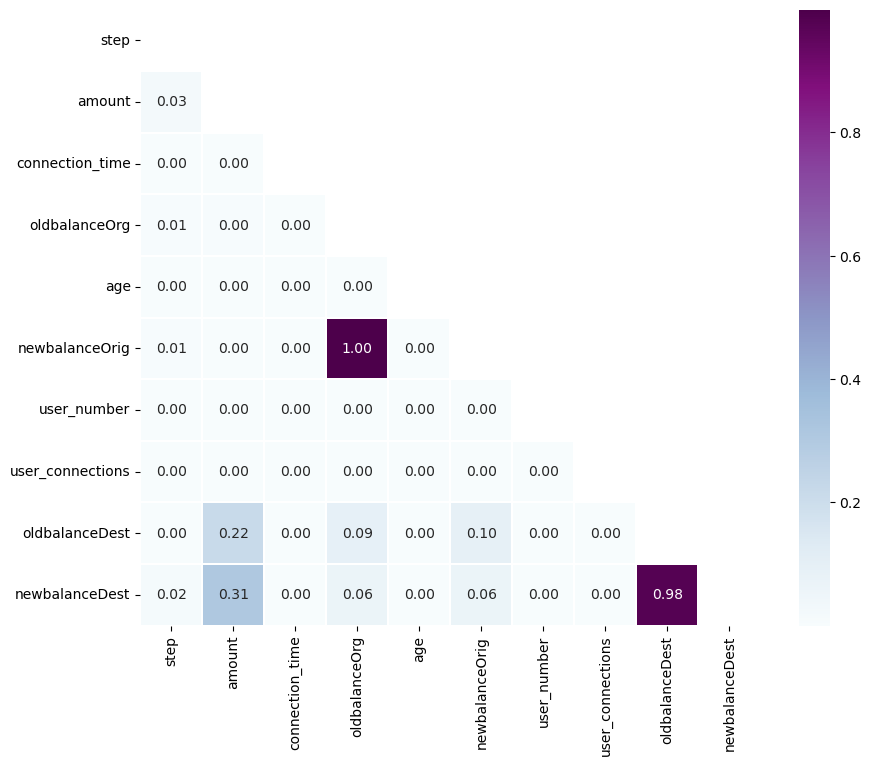

In [21]:
plt.figure(figsize = (10, 8))

sns.heatmap(corr.abs(), mask=mask, cmap ='BuPu', annot=True, fmt='.2f', linewidths=0.01)
plt.show()

Como era de esperar, la correlación entre los balances de origen y destino respectivamente es muy alta. Además, se puede apreciar una correlación leve entre los balances de destino y la cantidad de la operación.

#### Categóricas

Las columnas `nameOrig` y `nameDest` son identificadores por lo que presentan demasiados valores únicos y no tiene sentido analizar su relación con el resto de variables categóricas

In [22]:
categorical_data = data_eda[data_category].drop(['nameOrig', 'nameDest'], axis=1)

cramer_matrix = np.zeros((len(categorical_data.columns),len(categorical_data.columns)))

for i in range(0,len(categorical_data.columns)):
    for j in range(0,len(categorical_data.columns)):
        cramer_matrix[i,j]=cramers_v(categorical_data.iloc[:,i],categorical_data.iloc[:,j])
        
mask = np.zeros_like(cramer_matrix, dtype='bool')
mask[np.triu_indices_from(mask)] = True

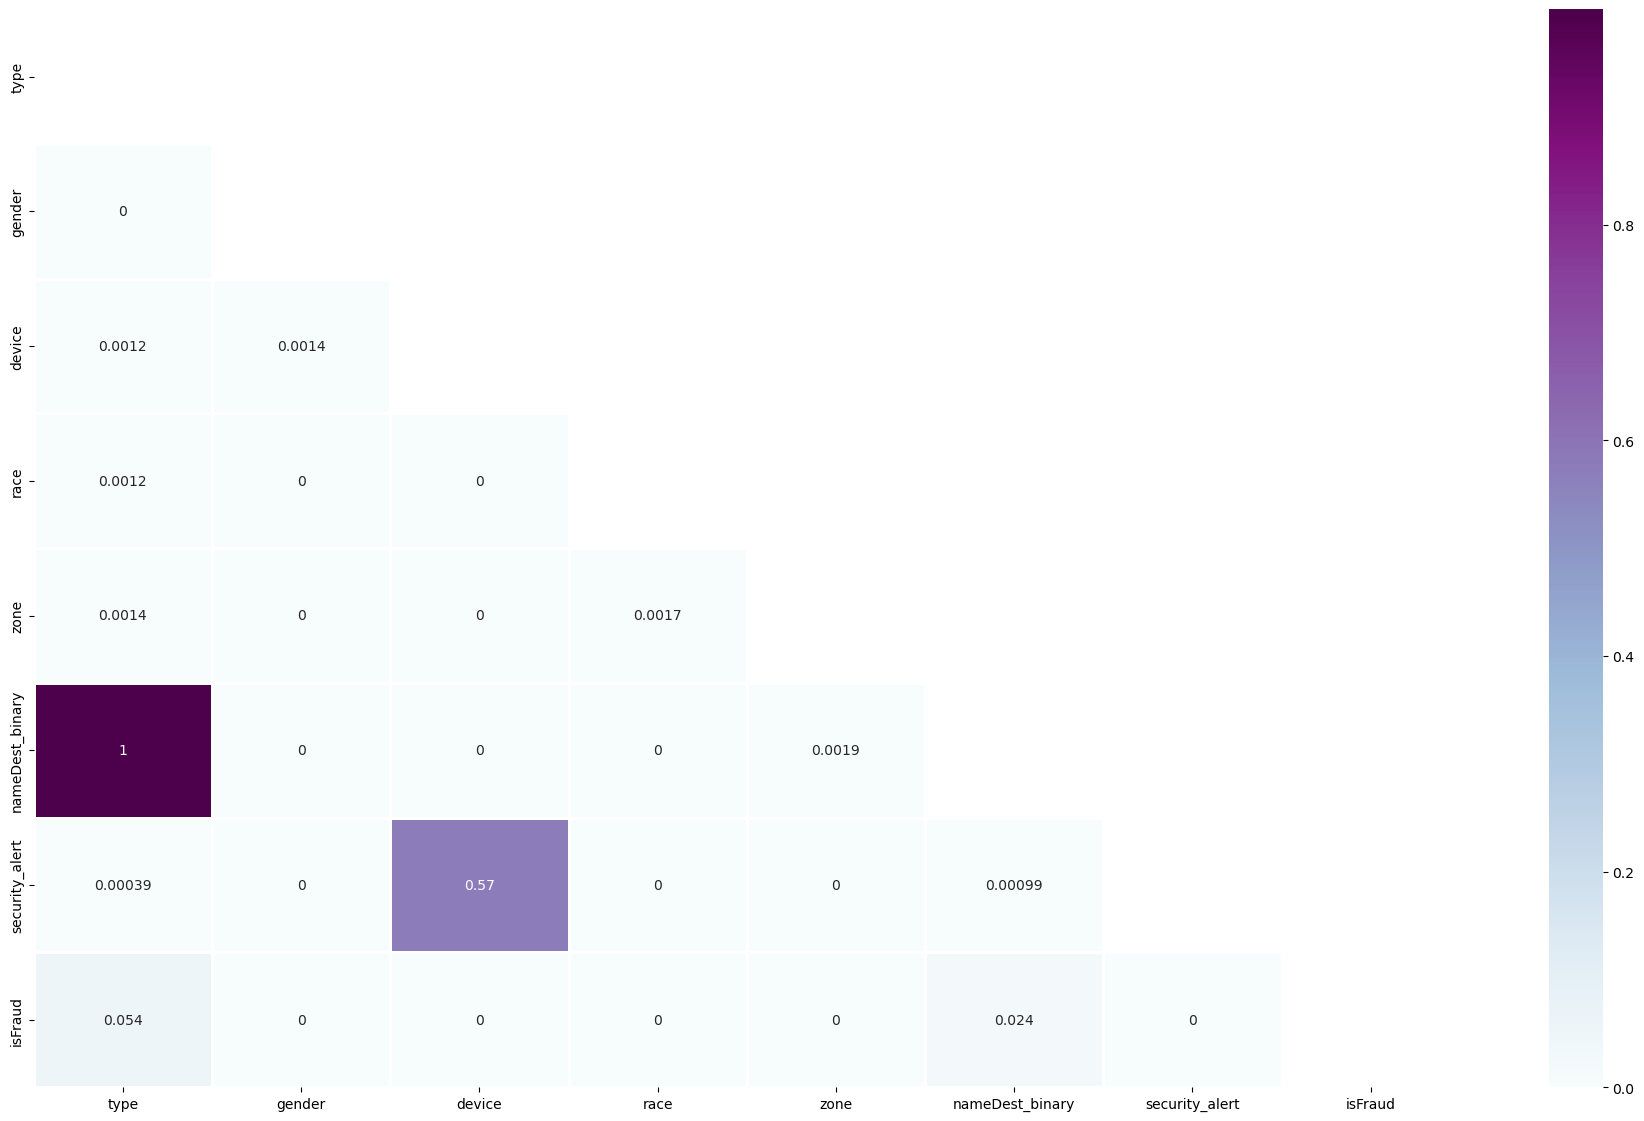

In [23]:
fig, ax = plt.subplots(figsize=(23, 14))
ax.plot()
ax = sns.heatmap(cramer_matrix, mask=mask, annot=True, linewidths=0.9, cmap="BuPu", 
                 xticklabels=categorical_data.columns, yticklabels=categorical_data.columns)

La asociación entre el tipo de transacción y el tipo de identificador de destino es máxima, por lo que es posible que la información generada con esta variable binaria sea redundante. Además, el tipo de dispositivo tiene un grado de asociación elevado con el hecho de si hubo alerta de seguridad o no en el día de la operación.

### Representación gráfica de las variables frente al target

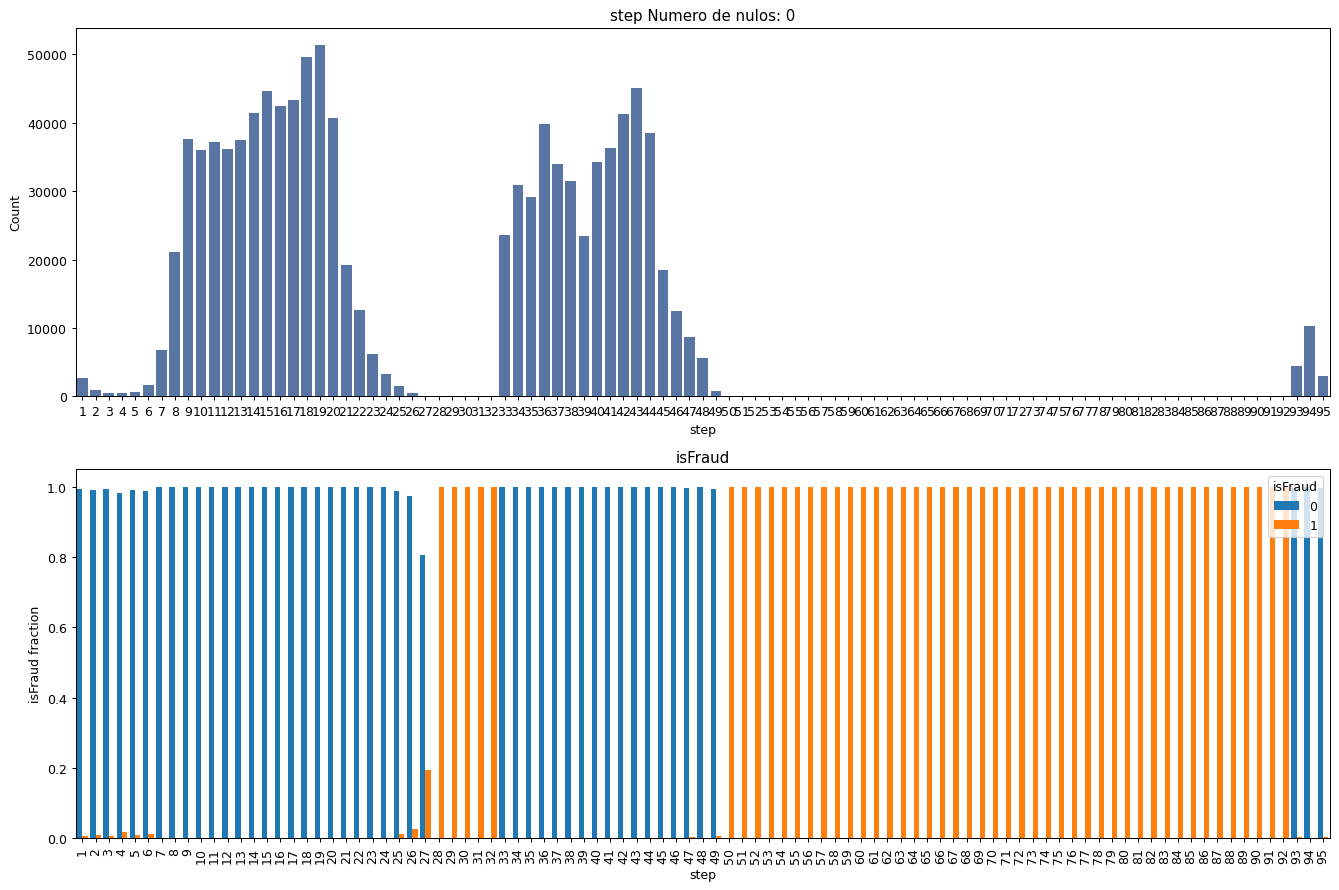

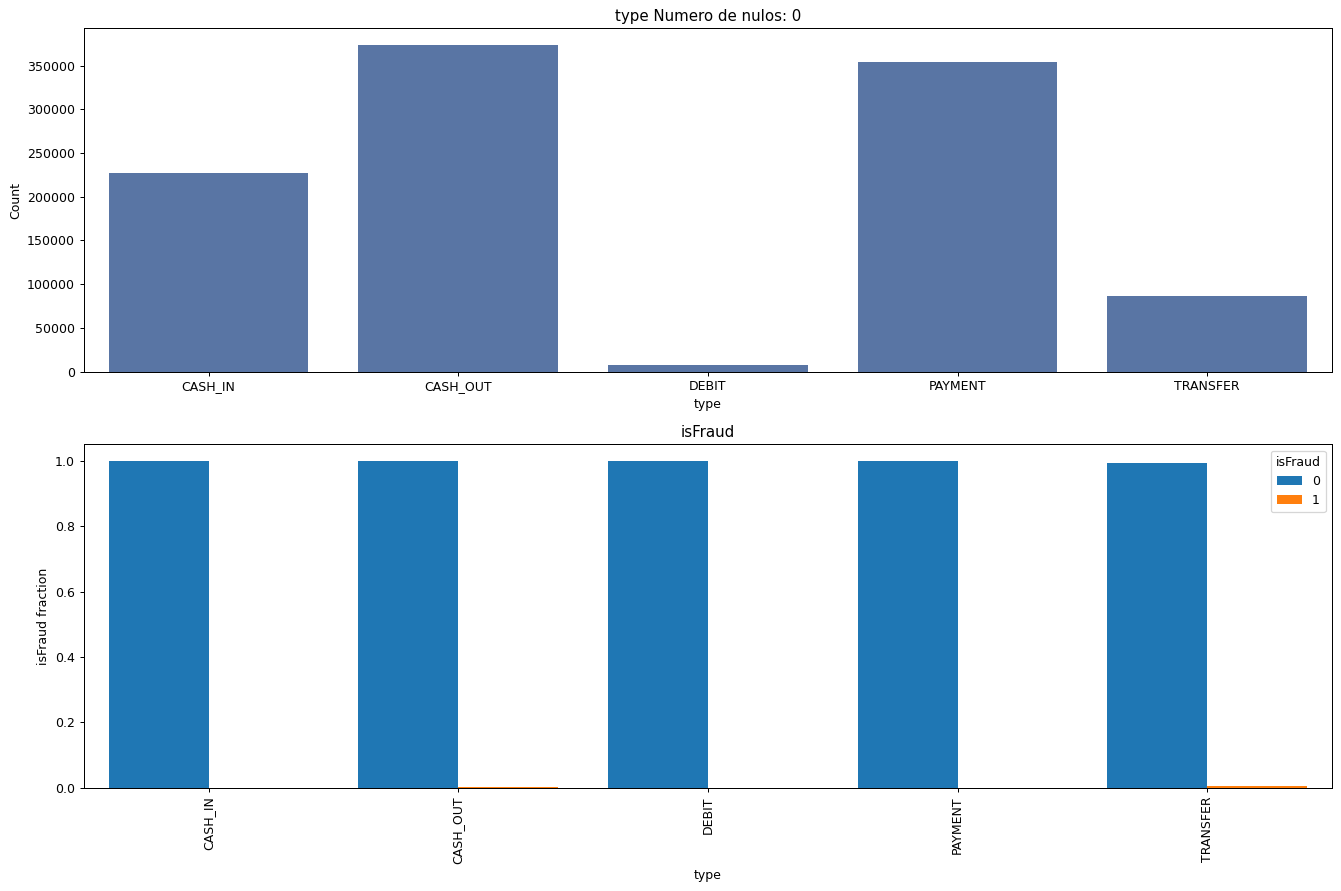

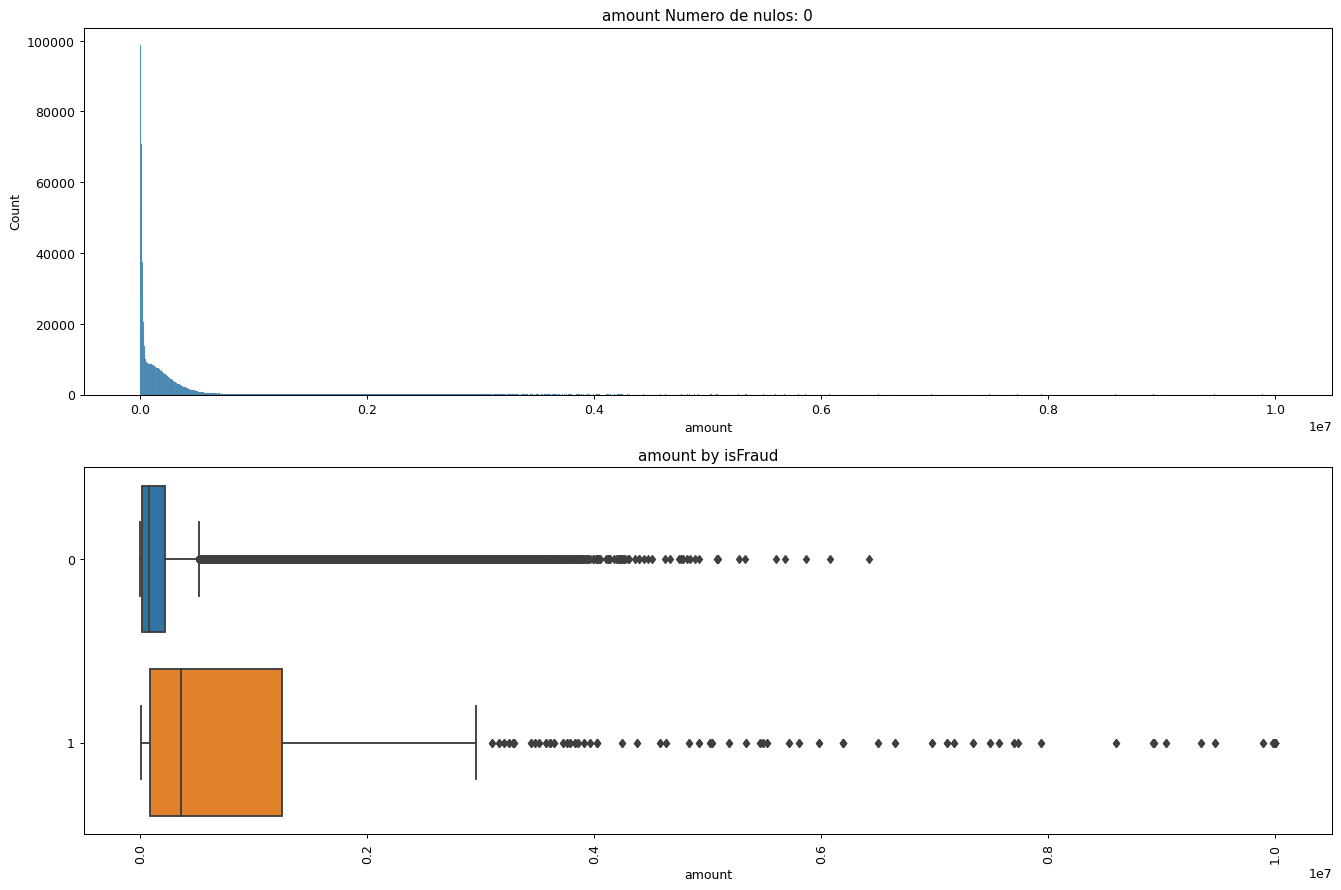

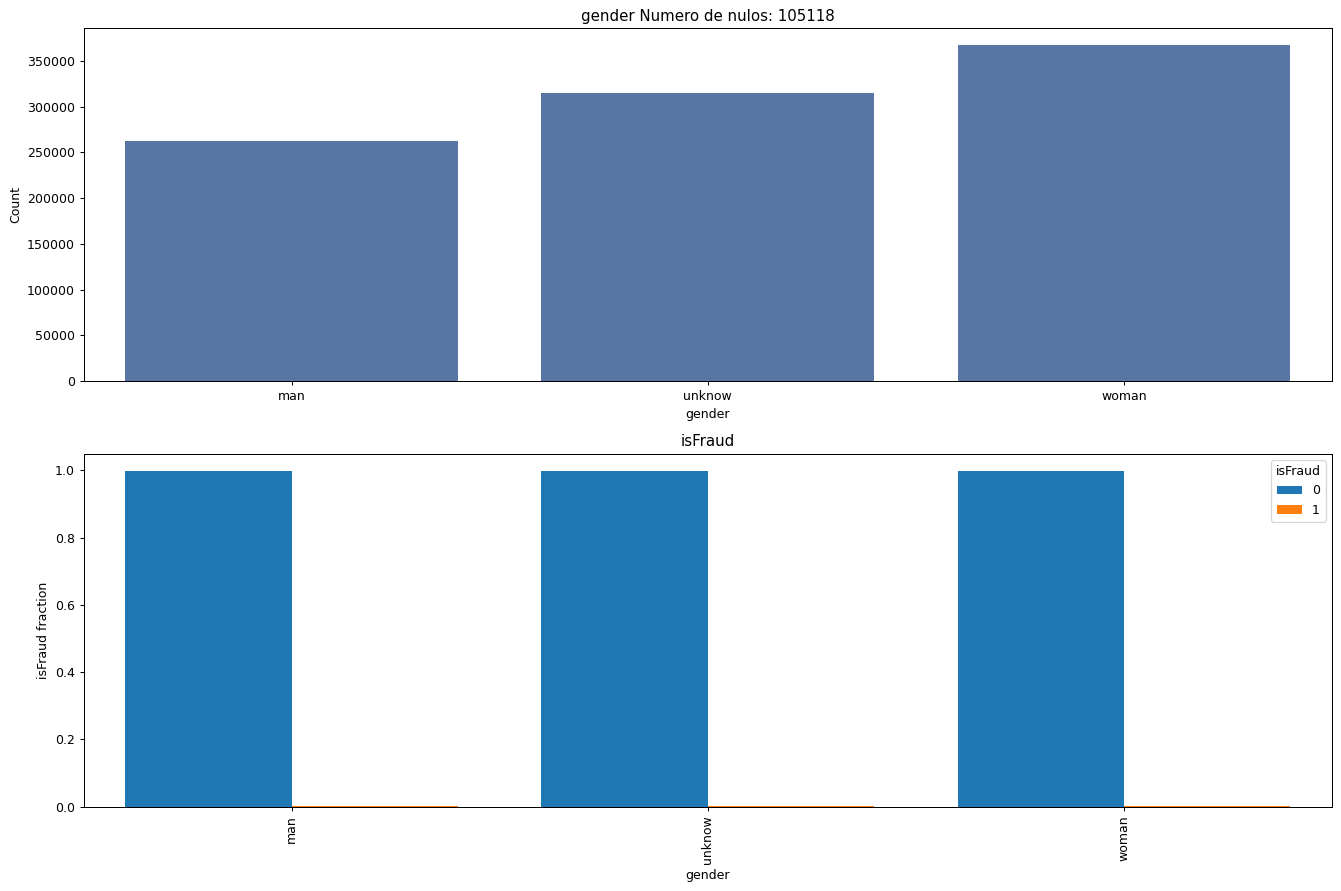

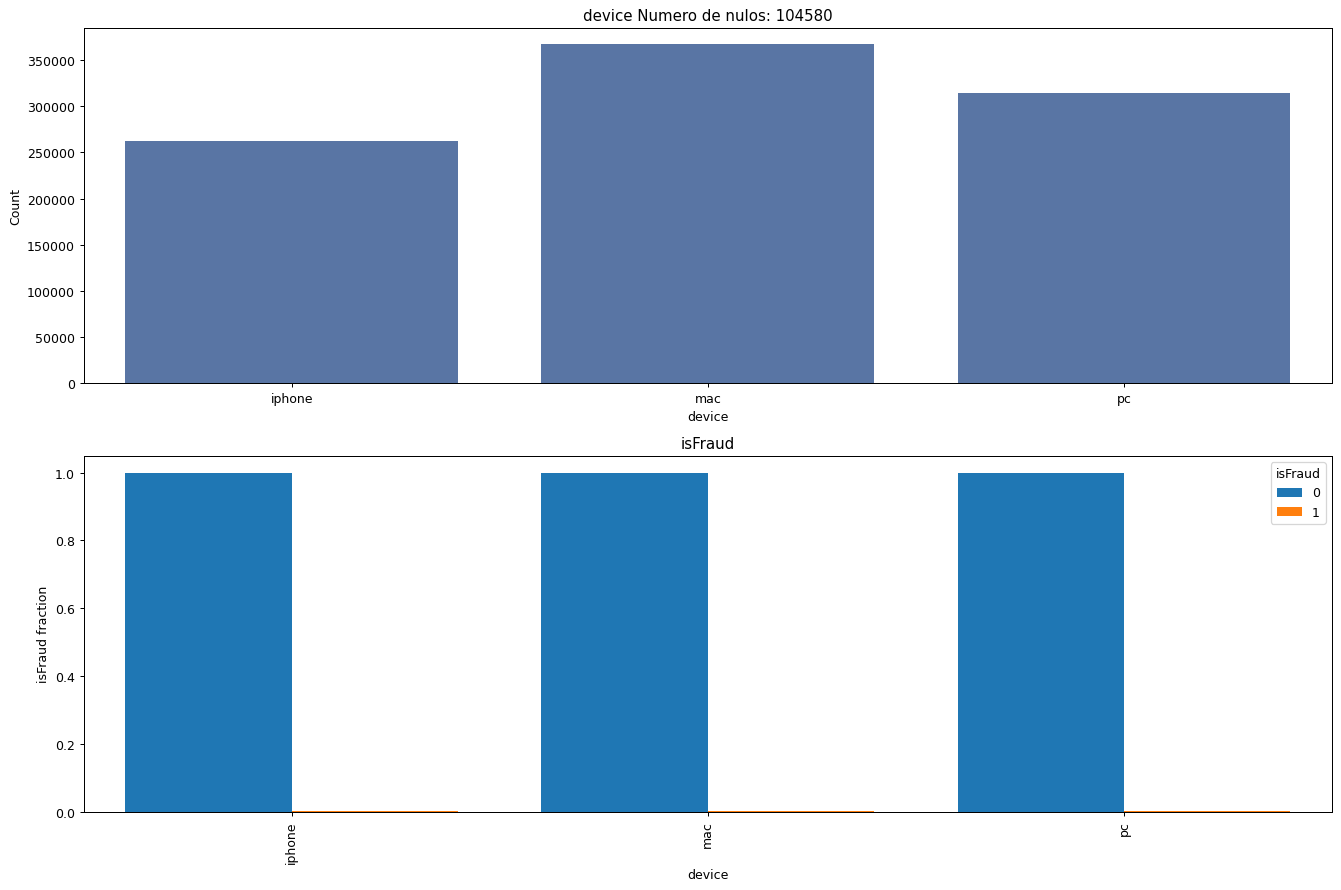

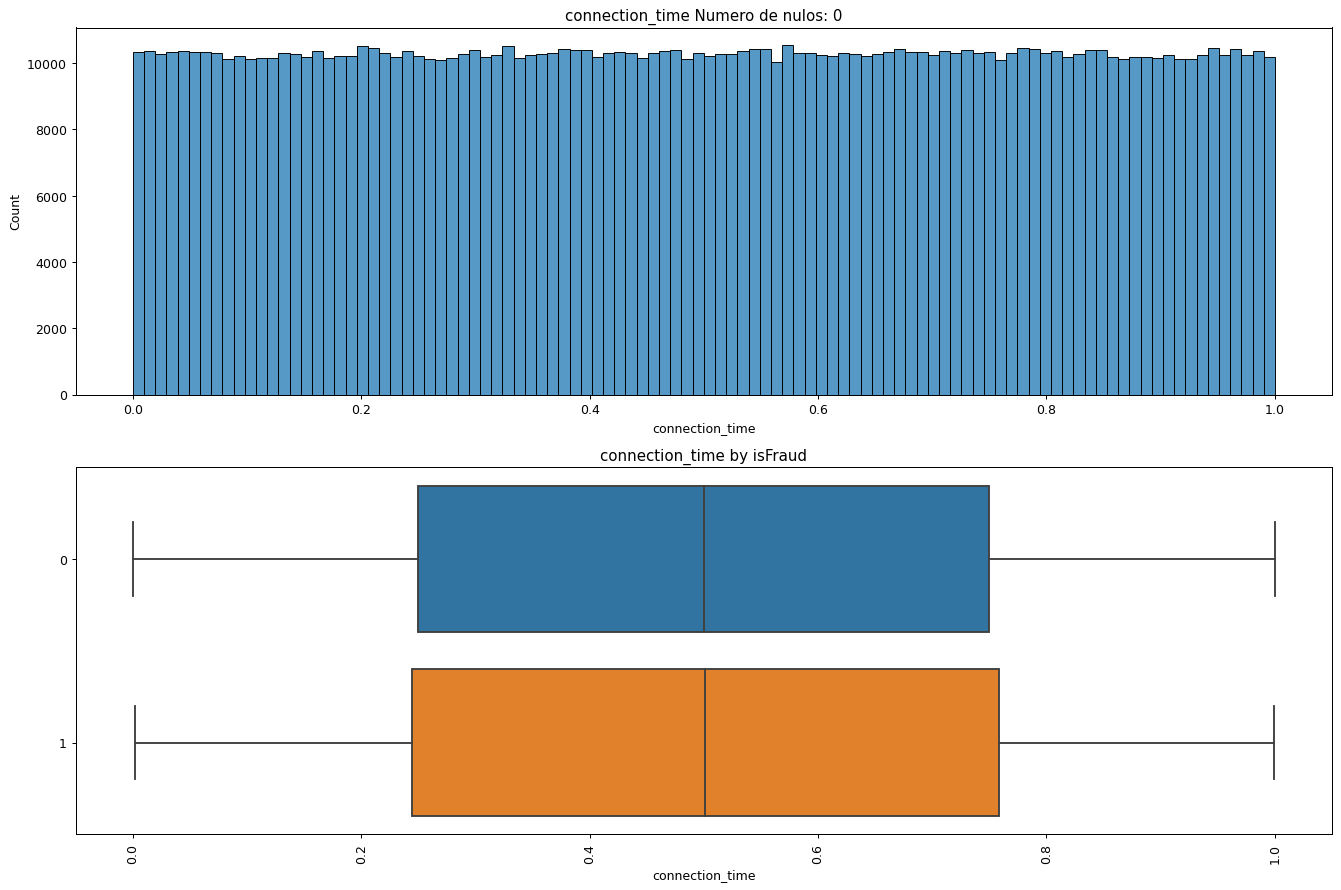

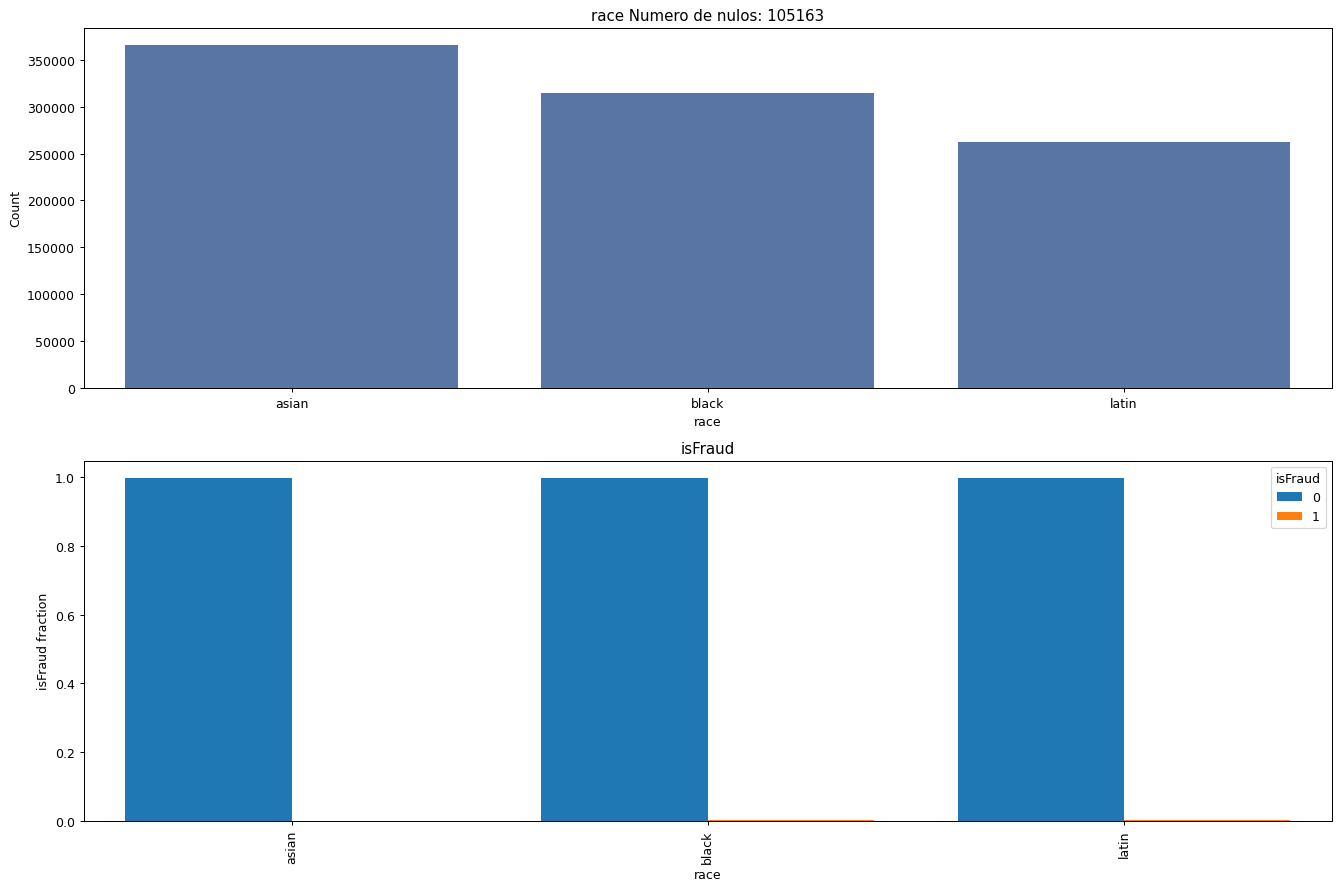

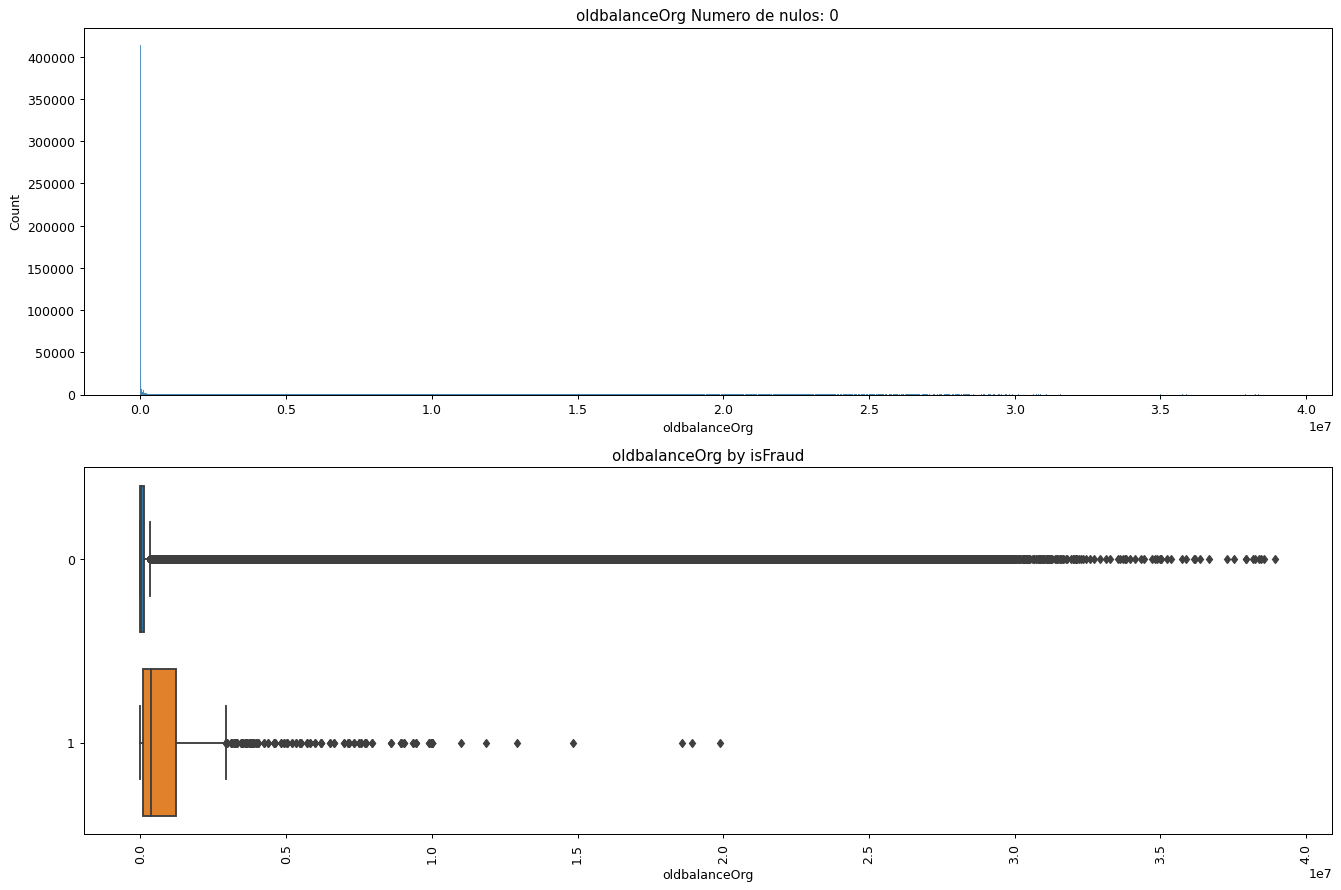

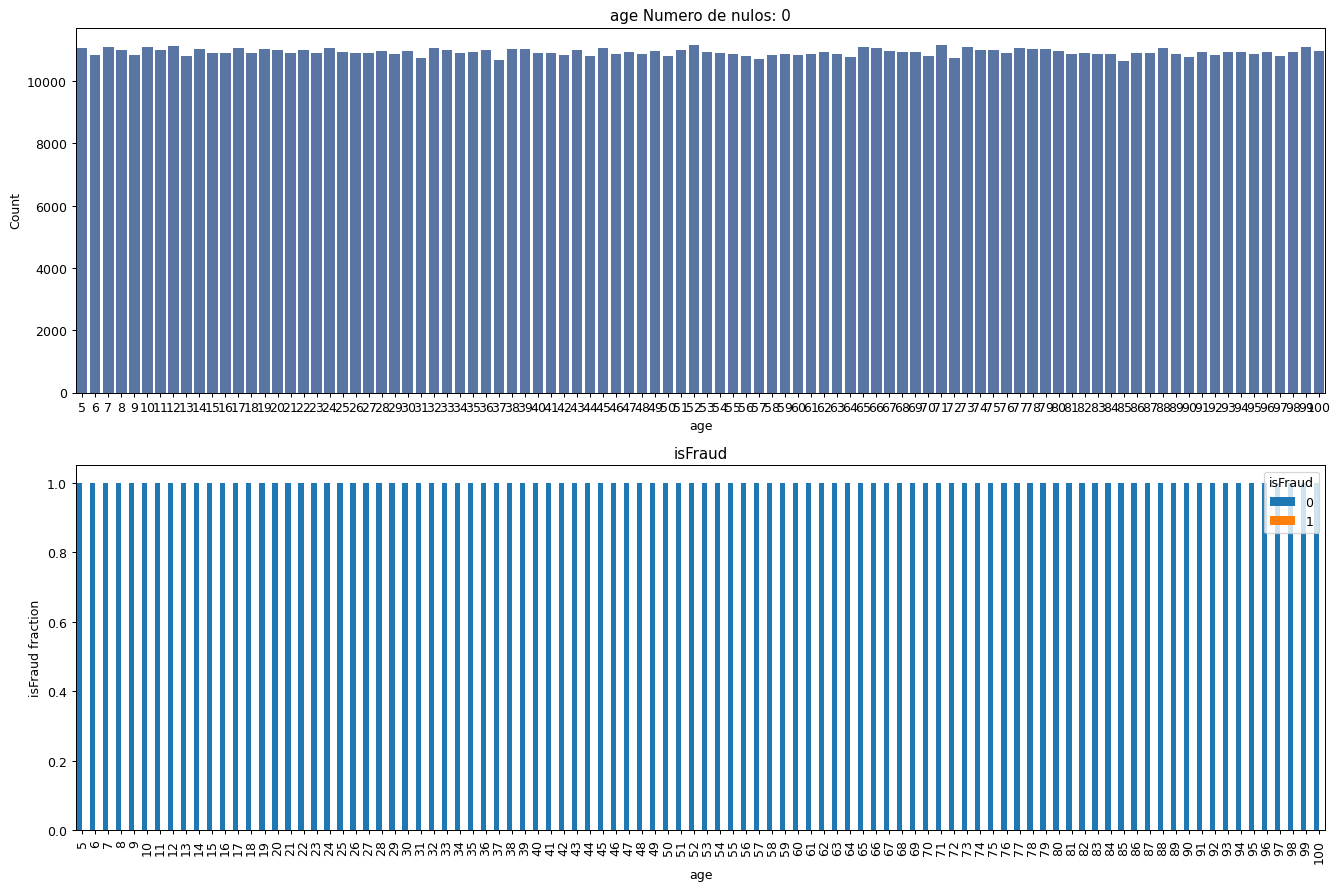

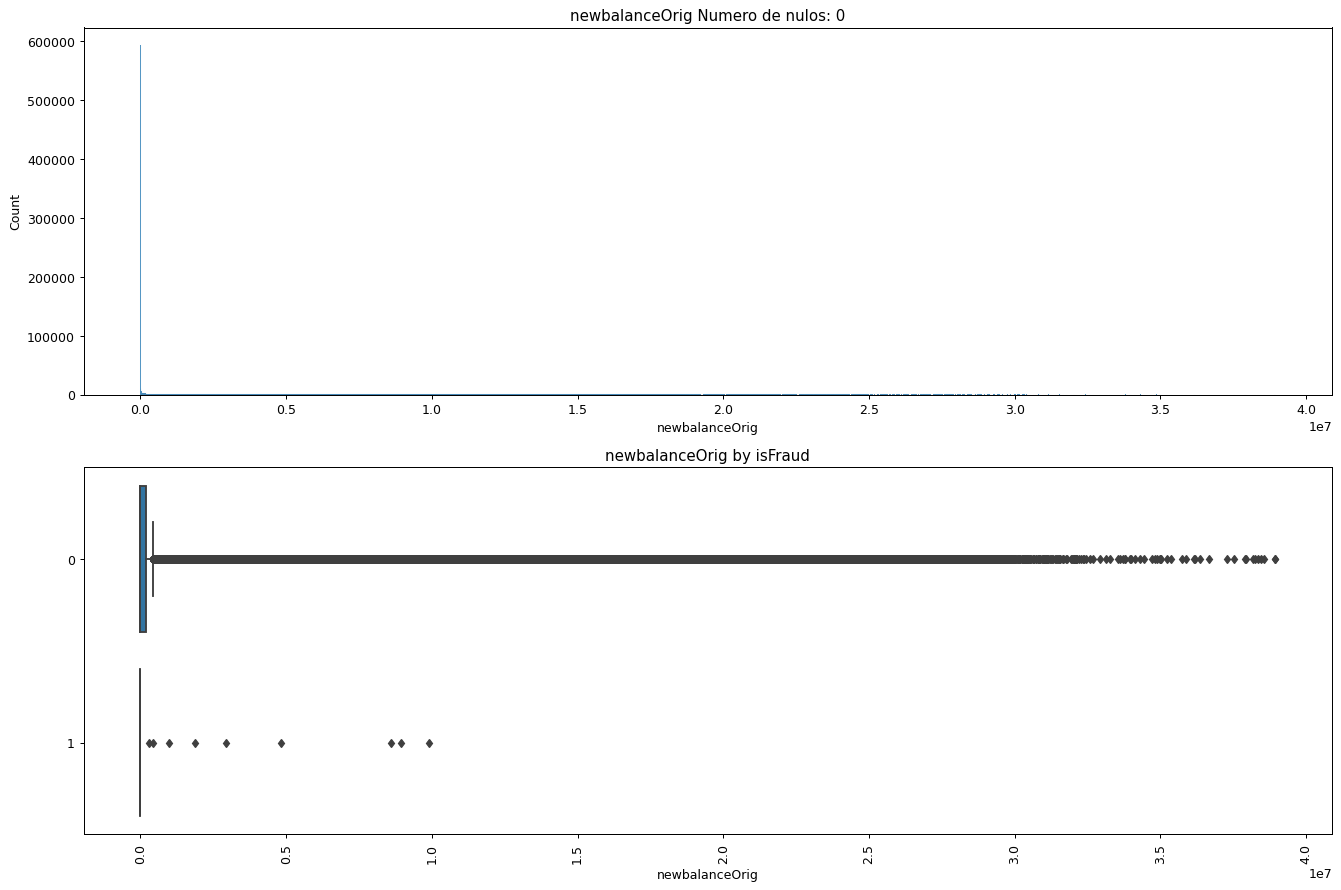

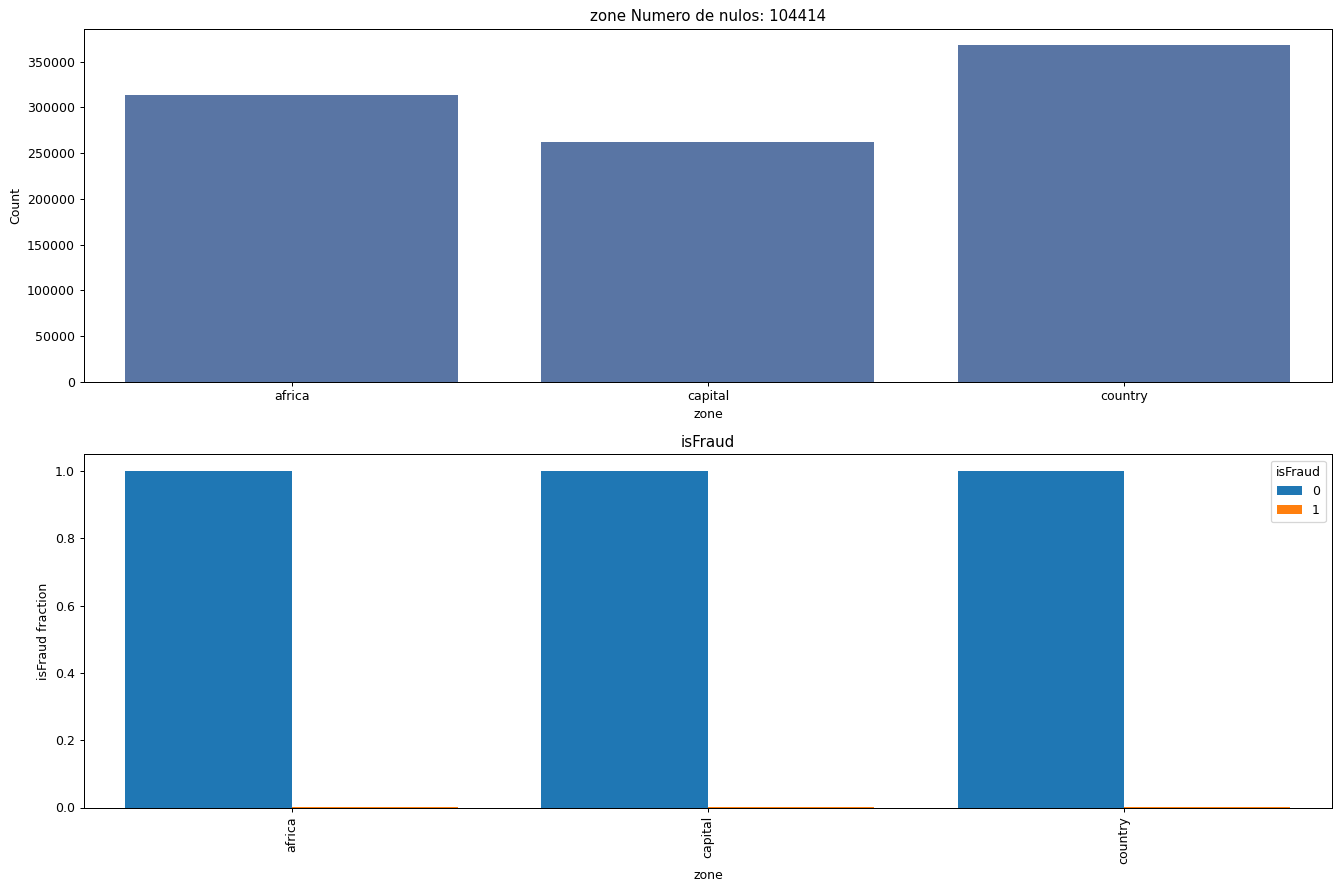

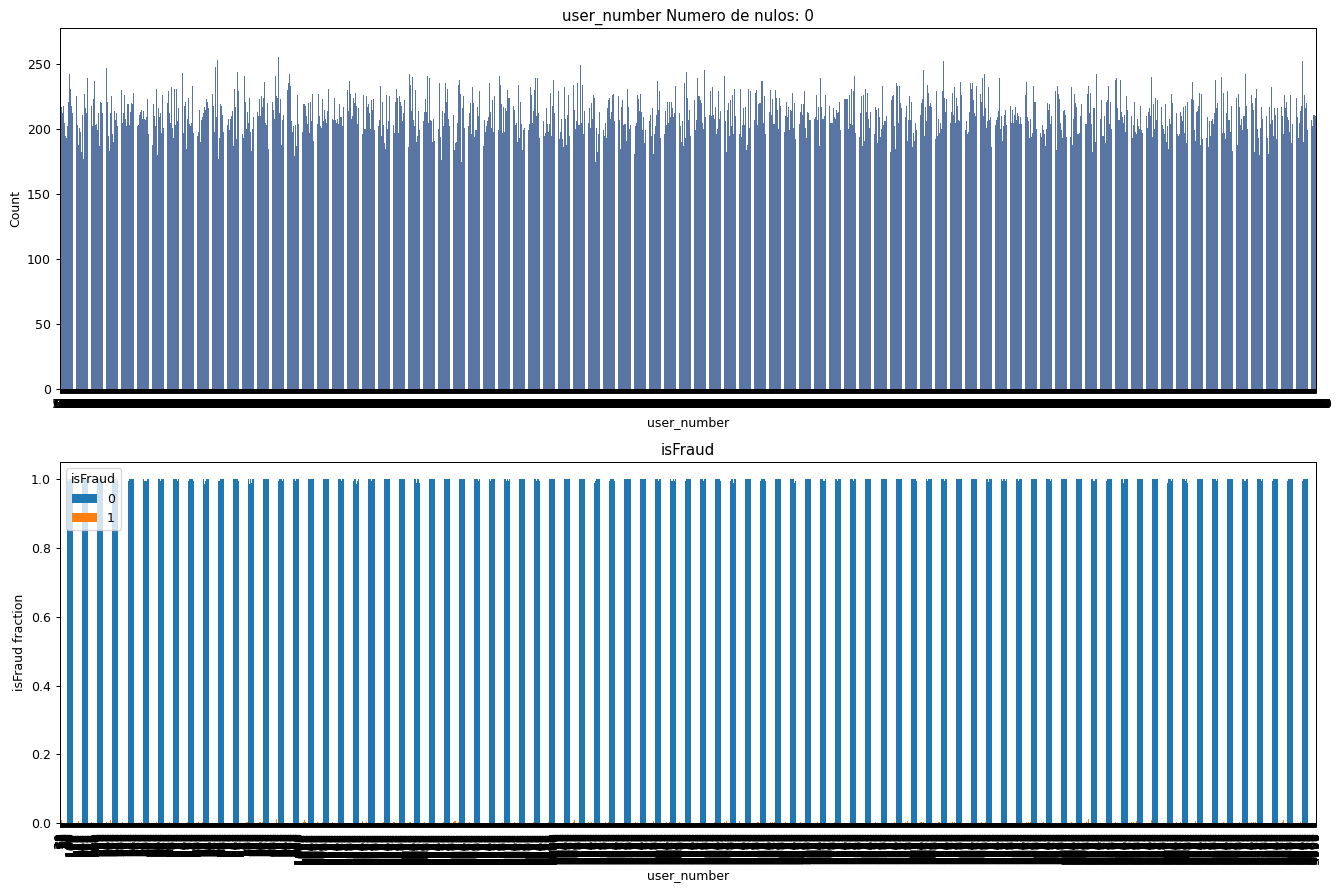

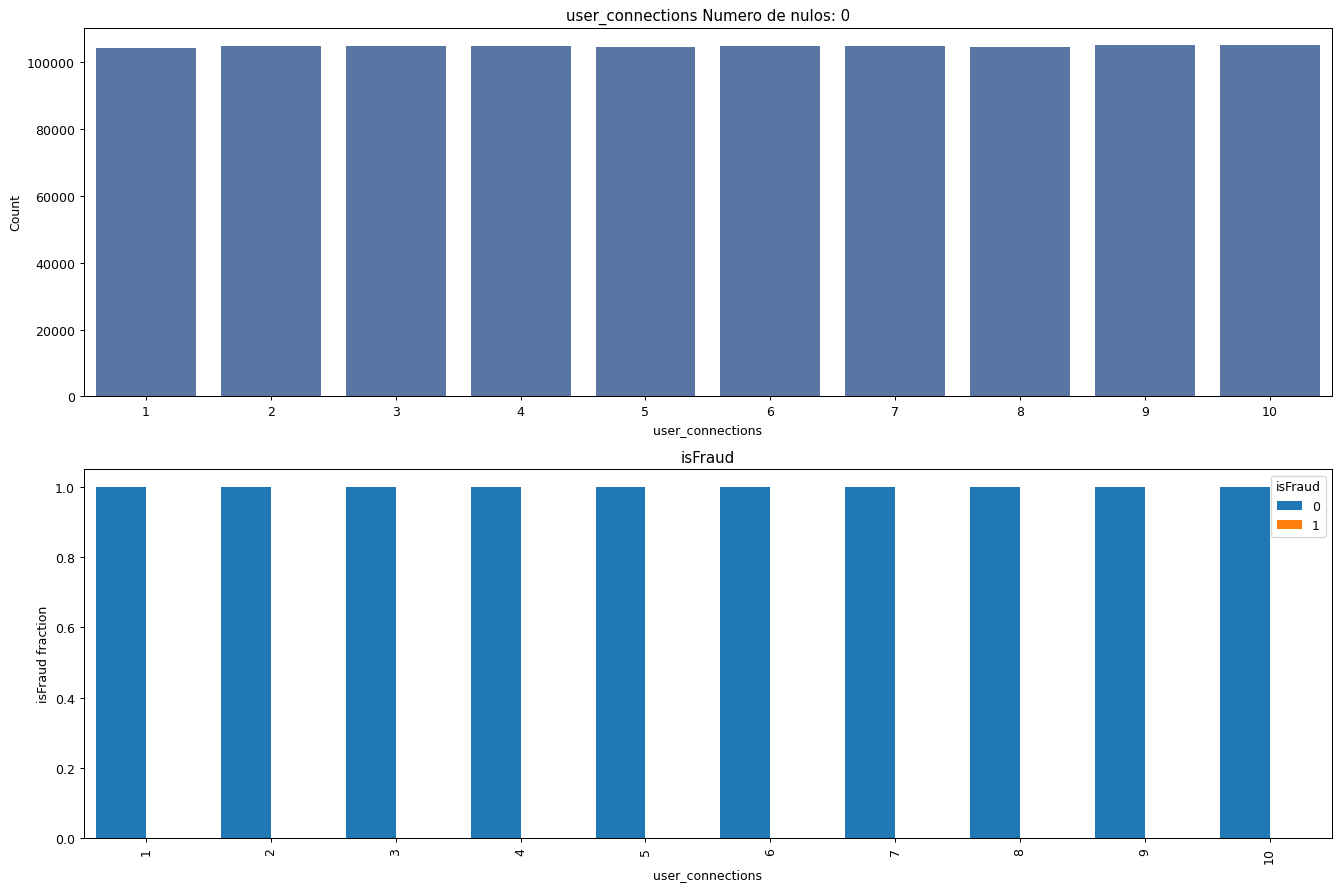

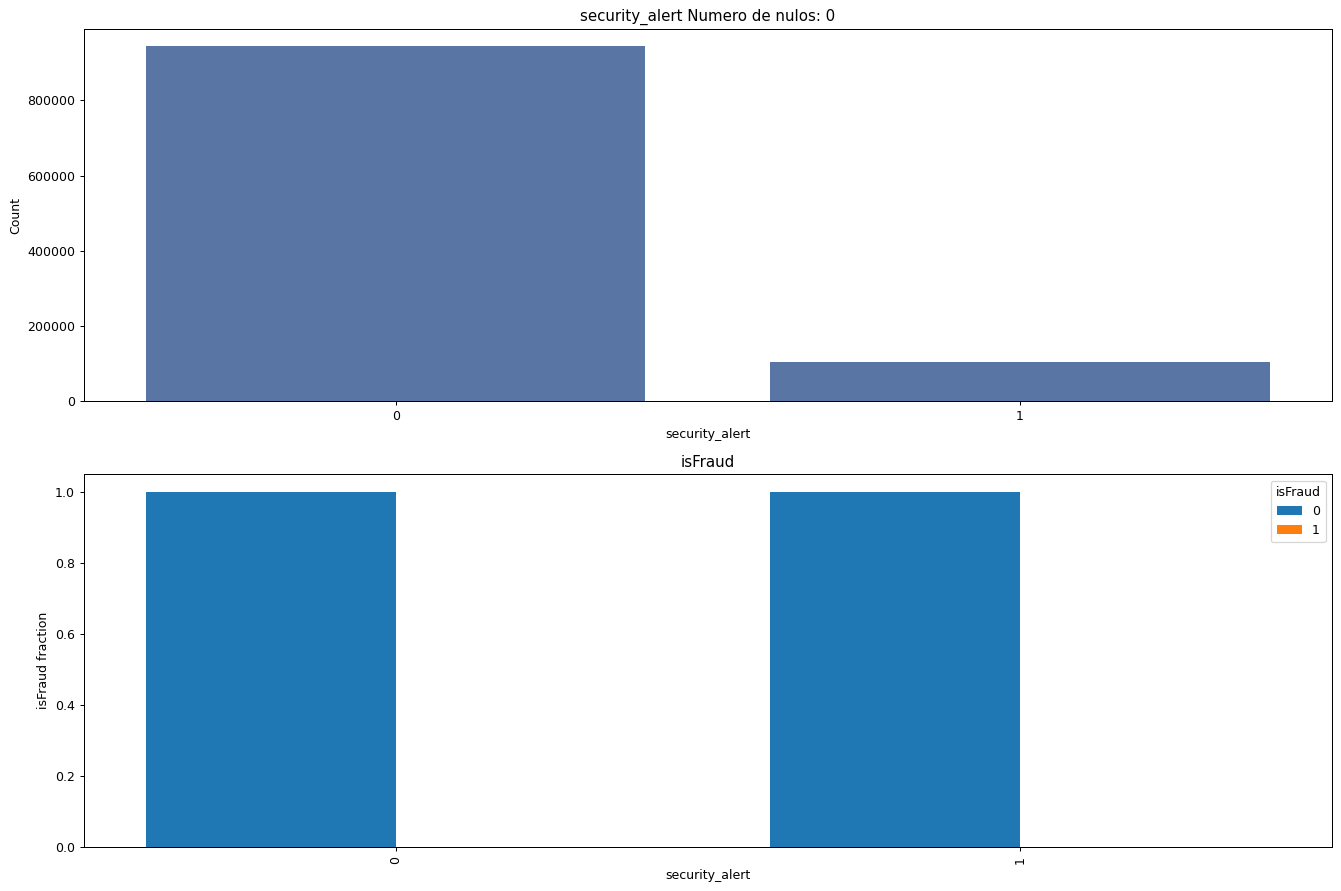

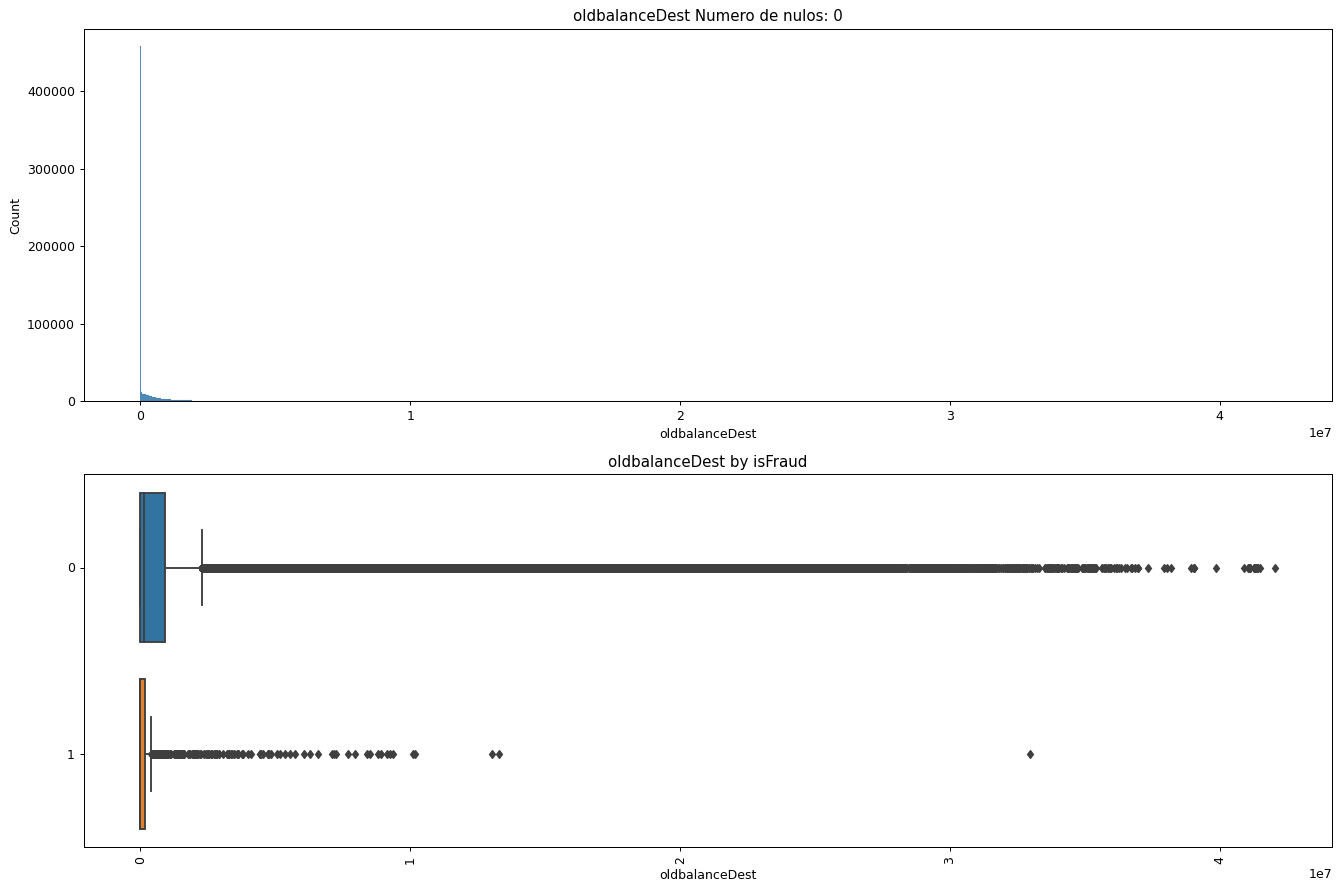

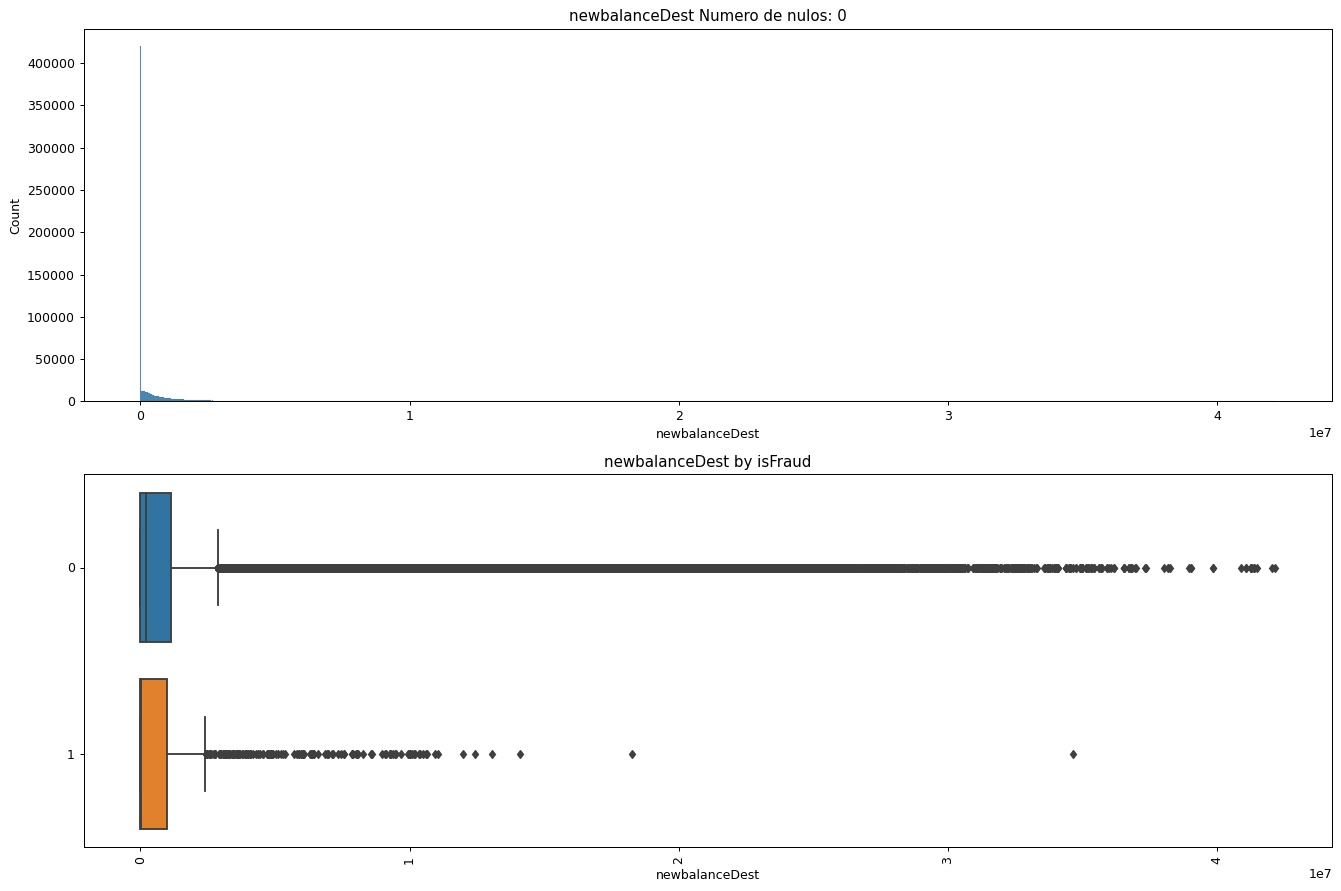

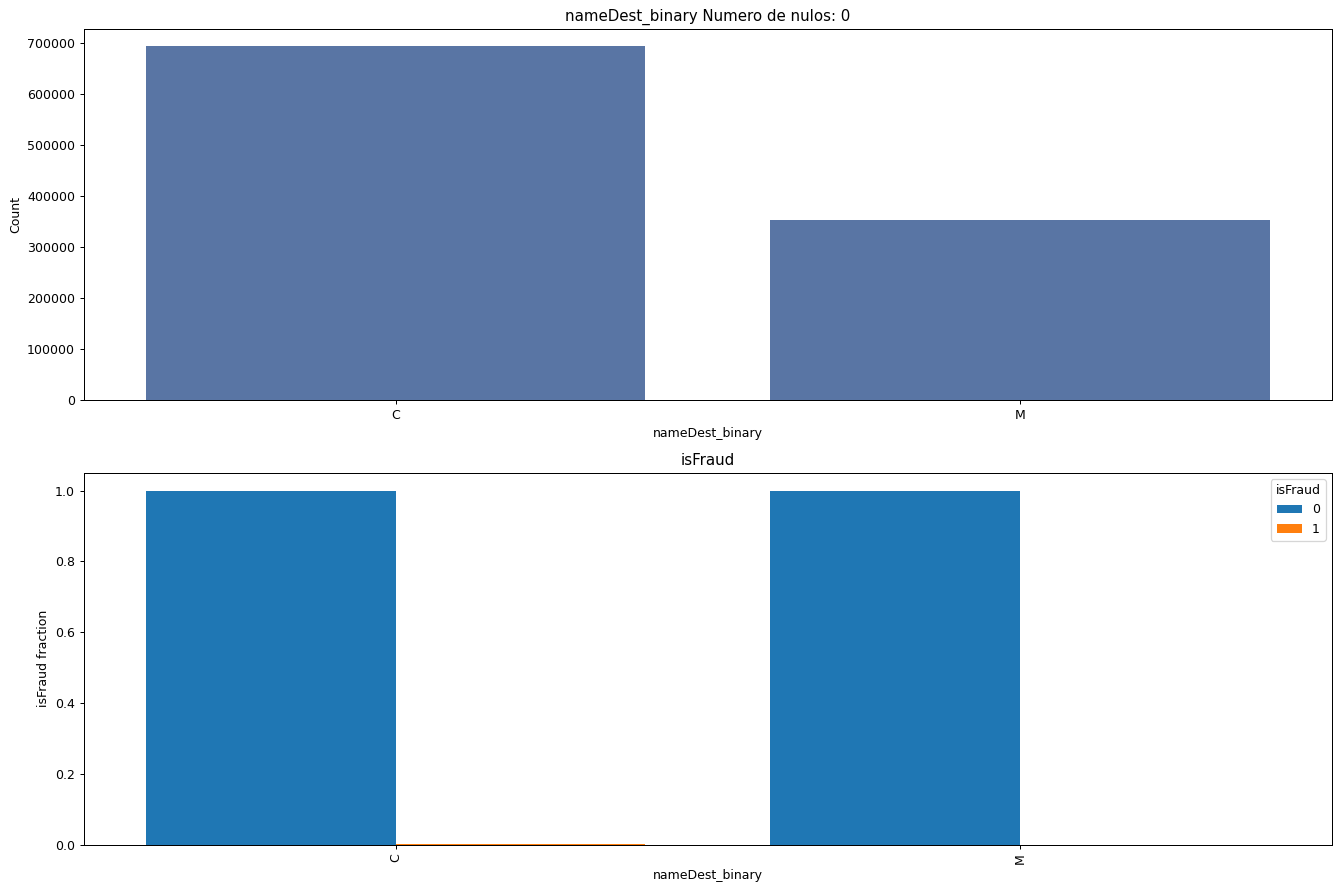

In [24]:
warnings.filterwarnings('ignore')
for i in list(data_eda.drop(['nameOrig','nameDest'],axis=1).columns):
    if (data_eda[i].dtype==float) & (i!='isFraud'):
        plot_feature(data_eda, col_name=i, isContinuous=True, target='isFraud')
    elif  i!='isFraud':
        plot_feature(data_eda, col_name=i, isContinuous=False, target='isFraud')

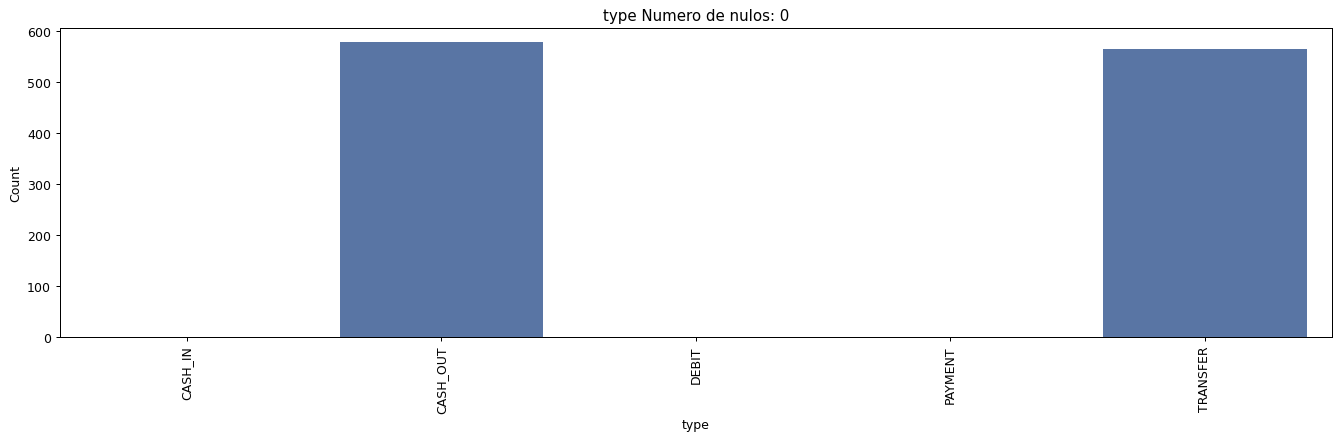

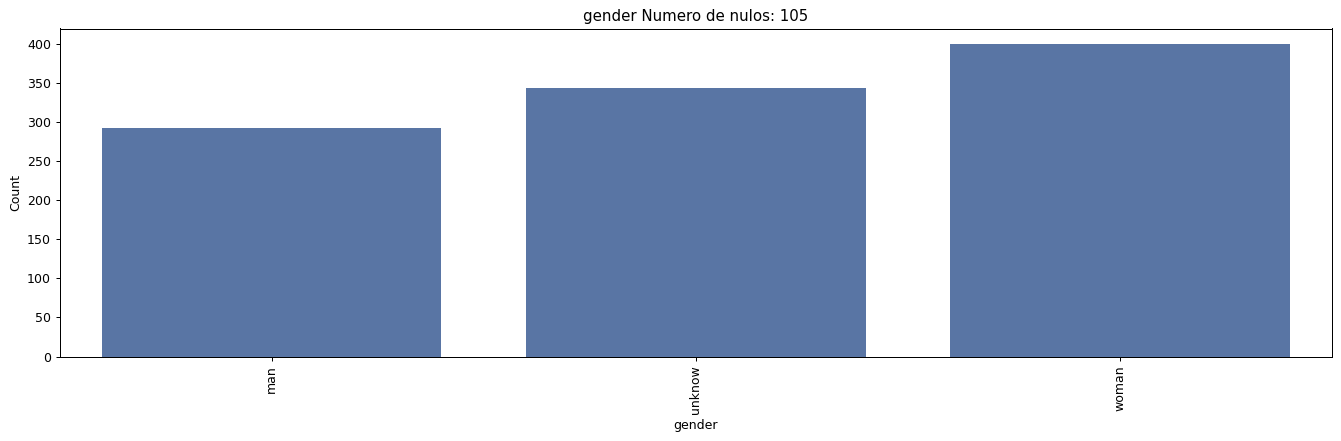

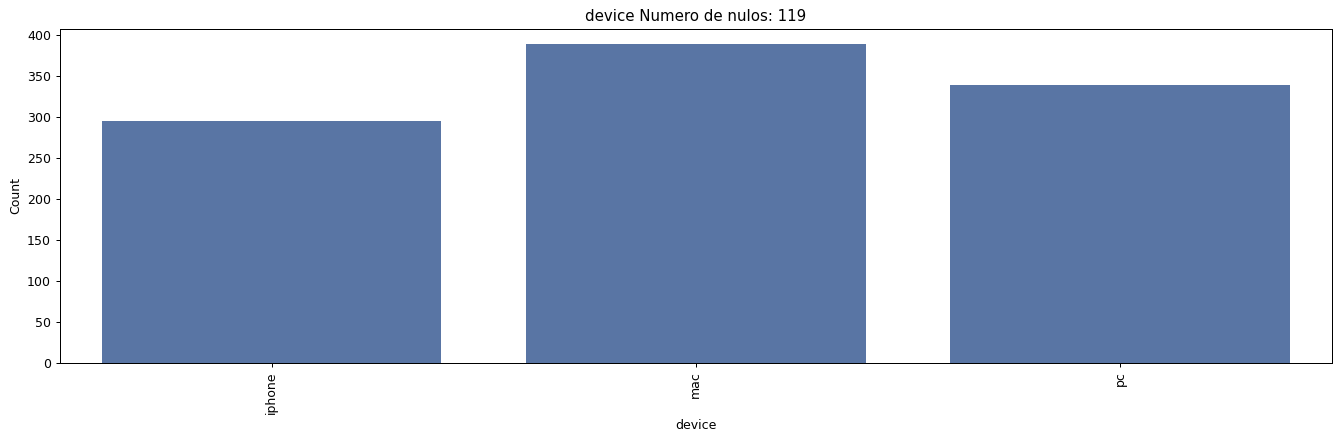

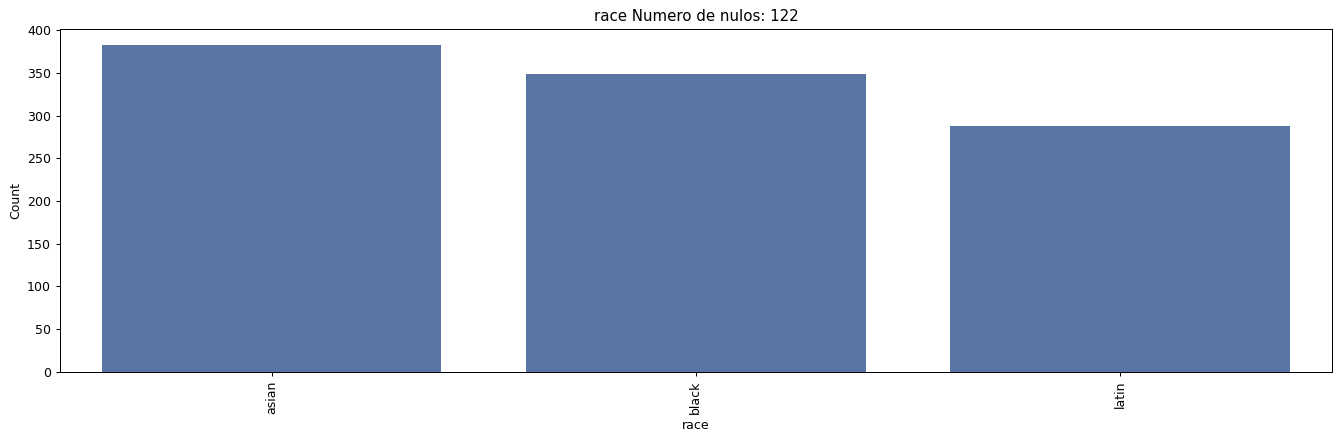

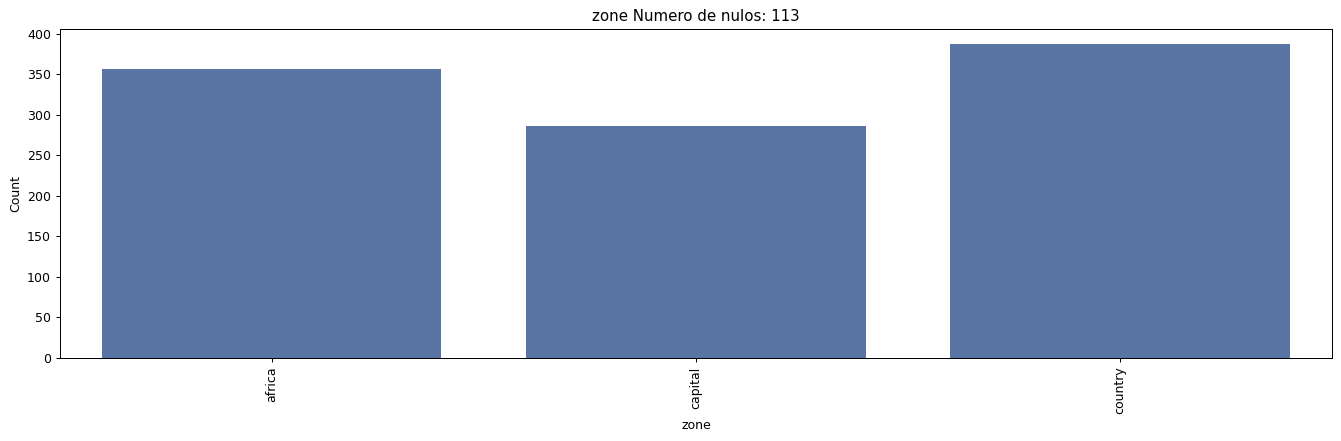

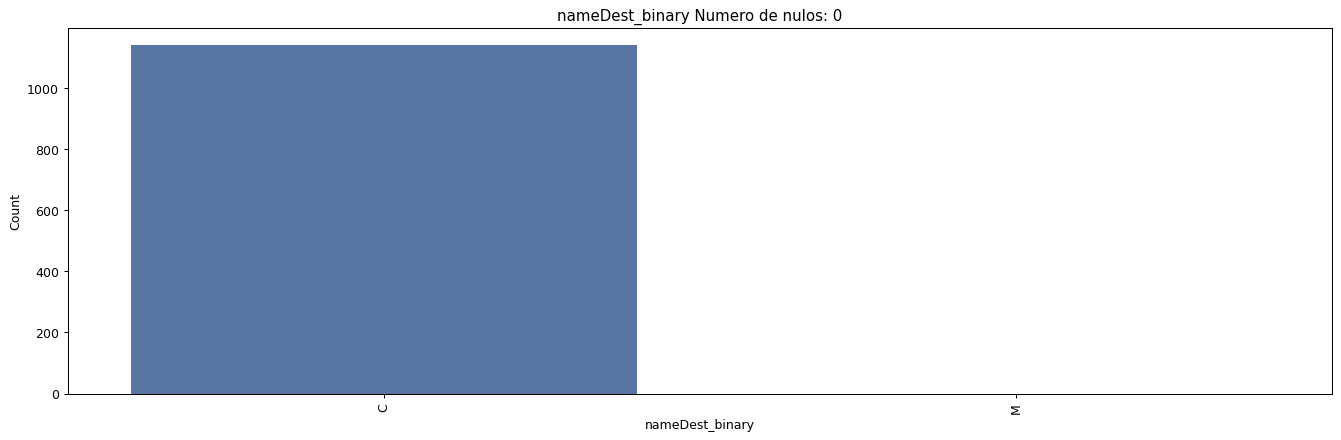

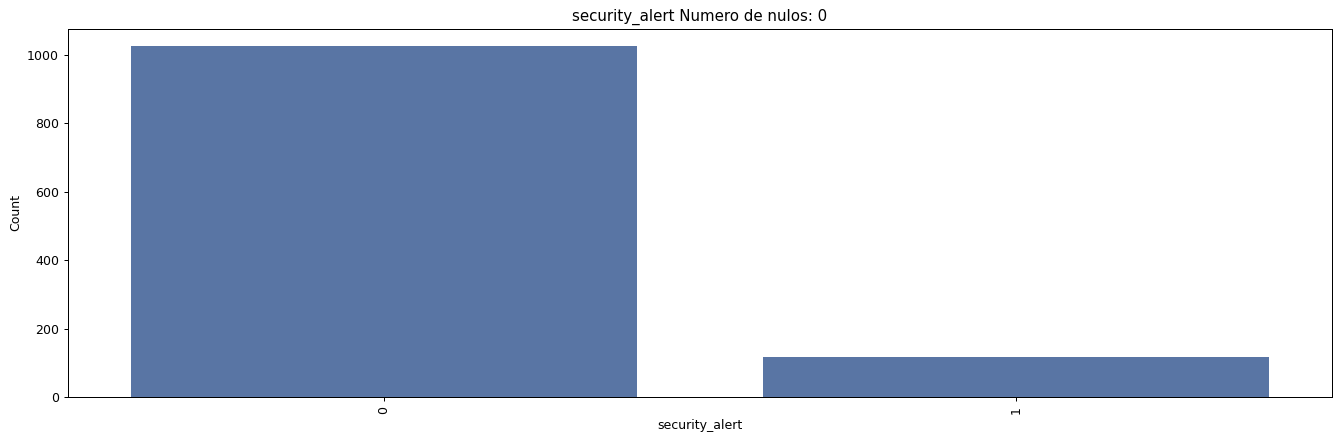

In [71]:
warnings.filterwarnings('ignore')
for i in list(data_eda[data_category].drop(['nameOrig','nameDest','isFraud'],axis=1).columns):
    plot_fraud(data_eda[data_eda["isFraud"] == 1], col_name=i)


Como las variables `nameDest` y `nameOrig` son identificadores, no las consideramos a la hora de realizar el KNN.

In [ ]:
data_backup = data.copy()
data_backup.drop(['nameDest','nameOrig'], axis=1, inplace=True)

In [ ]:
data_backup['gender']=data_backup['gender'].replace(['man', 'woman', 'unknow'],
                        [1,2,3]).astype('Int64')
data_backup['zone']=data_backup['gender'].replace(['capital', 'country', 'africa'],
                        [1,2,3]).astype('Int64')

In [ ]:
INPUTS_KNN_NUM = ['step','amount','connection_time','oldbalanceOrg','age','newbalanceOrig',
                'user_number','user_connections','oldbalanceDest','newbalanceDest']
INPUTS_KNN_CAT = ['type','device','security_alert','isFraud']
numeric_transformer = MinMaxScaler()
category_transformer = make_column_transformer((OneHotEncoder(), INPUTS_KNN_CAT),
                                               remainder='passthrough')

In [ ]:
numeric_transformer.fit(data_backup[INPUTS_KNN_NUM])
data_backup[INPUTS_KNN_NUM] = numeric_transformer.transform(data_backup[INPUTS_KNN_NUM])

In [ ]:
transformed = category_transformer.fit_transform(data_backup)
data_backup = pd.DataFrame(transformed, columns=category_transformer.get_feature_names_out())
cols = data_backup.columns
data_backup[cols] = data_backup[cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
data_backup.head(20)

In [ ]:
data_backup.dtypes

In [ ]:
imputer = KNNImputer()  # tell the imputer to consider only '#' as missing data
imputed_data = imputer.fit_transform(data_backup)  # impute all '#'
data2 = pd.DataFrame(data=imputed_data, columns=data_backup.columns)

In [ ]:
imputed_data = imputer.fit_transform(data_backup)  # impute all '#'
data2 = pd.DataFrame(data=imputed_data, columns=data_backup.columns)

In [ ]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_KNN_NUM = ['step','amount','connection_time','oldbalanceOrg','age','newbalanceOrig',
                'user_number','user_connections','oldbalanceDest','newbalanceDest']
INPUTS_KNN_CAT = ['type','device','raze']
INPUTS_KNN = INPUTS_KNN_NUM + INPUTS_KNN_CAT

## Configure model and hyparameter tuning
param = {'knnn_neighbors': range(3,120,4)} #Number of neighbors
#param = {'knnn_neighbors': [60]} # Uncomment in case only one parameter is wanted

numeric_transformer = Pipeline(steps=[('scaler',StandardScaler())]) # Preprocess the variables when training the model 

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_KNN_NUM),
        ('cat', categorical_transformer, INPUTS_KNN_CAT)
        ])

pipe = Pipeline(steps=[('Prep',preprocessor), # Preprocess the variables when training the model 
                           ('knn',KNeighborsRegressor())]) # Model to use in the pipeline

In [ ]:
from sklearn.impute import KNNImputer
import pandas as pd

cols_backup = df.columns
df['COL_TO_IMPUTE'].fillna('#', inplace=True)  # replace all missing data in desired column with with '#'
imputer = KNNImputer(missing_values='#')  # tell the imputer to consider only '#' as missing data
imputed_data = imputer.fit_transform(df)  # impute all '#'
df = pd.DataFrame(data=imputed_data, columns=cols_backup)

In [ ]:
# data['gender']=data['gender'].replace(['man', 'woman', 'unknow'],
#                         [1,2,3]).astype('Int64')
# data['gender']


In [ ]:
imputer = KNNImputer(n_neighbors=3, weights="uniform")
model = imputer.fit(data)
data_imputed = model.transform(data)

In [ ]:
class HealthyAttributeAdder(BaseEstimator, TransformerMixin):
    def fit(self, X , y=None):
        return self
    def transform(self, X):
        #X = X.copy()
        temp_cols = X.columns.to_list()
        temp_cols.append('healthy')
        new_cols = {k:v for k,v in zip(range(len(temp_cols)),temp_cols)}
        healthy = X.apply(lambda row: determine_healthy(row), axis=1)
        combined_df = pd.DataFrame(np.c_[X, healthy]).rename(columns=new_cols)
        return combined_df

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso

transform_pipeline = ColumnTransformer([
    #('healthy', HealthyAttributeAdder(), all_col),
    ('ss', StandardScaler(), num_col),
    ('ohe', OneHotEncoder(drop='first'), cat_col),
])

healthy_pipeline = Pipeline([
    ('healthy', HealthyAttributeAdder())                          
])

price_pipeline = Pipeline([
    ('add_healthy', healthy_pipeline),                     
    ('transform', transform_pipeline),
    ('lasso',Lasso())
])

price_pipeline.fit(X_train,y_train)
y_pred = price_pipeline.predict(X_test)

In [ ]:
# there's a typo in this column regarding the row-value 'unknown' so we correct it to proceed with the analysis.
data_raw= data_raw.assign(**{'gender': lambda df: df['gender'].replace({
    'unknow': 'unknown'})})


gender_dist = data_raw['gender'].value_counts(normalize=True, dropna=True)*100
gender_dist


nans = data_raw['gender'].isna()
length = sum(nans)
data_raw['gender'][data_raw['gender'].isna()] = random.choices(['woman', 'unknown', 'man'], weights=[gender_dist.iloc[0], gender_dist.iloc[1], gender_dist.iloc[2]], k=length)